In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 80
# BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [3]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)


def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [6]:
# Read CSV
#dataset = pd.read_csv(DATASET_NAME)
dataset = pd.read_csv("creditcard.csv")
assert not dataset.isnull().values.any()
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

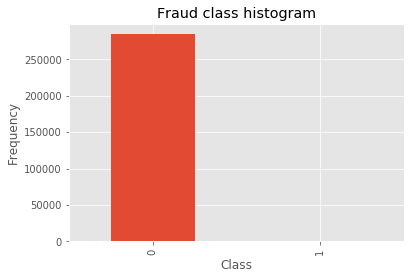

0    284315
1       492
Name: Class, dtype: int64

In [6]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [7]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = split_data(dataset, train_size=0.8)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [8]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


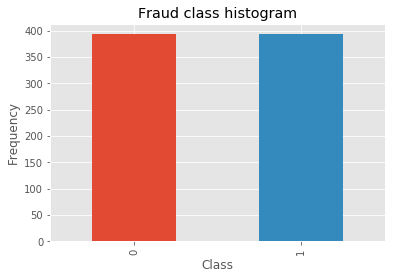

0    393
1    393
Name: Class, dtype: int64

In [9]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [10]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [111]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss)
        print("Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_tr, y_tr, x_val=None, y_val=None):
        for i in range(self.epochs):
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.BIG_DELTAS = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(x_tr, y_tr, x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [112]:
# k-fold validation with k=5
k_fold_split_array = k_fold_split_data(under_sample_dataset, 5)
models = []
for n, validation in enumerate(k_fold_split_array):
    train = k_fold_split_array.copy()
    train.pop(n)
    train = np.concatenate(train)

    x_train = train[:, :-1]
    y_train = train[:, -1:]

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

    # 653
    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation)
    
    print("\n", '='*80)
    print("Validation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    models.append(model)

Loss:  0.163606881508
Accuracy:  0.7158730158730159
Loss:  0.162827212733
Accuracy:  0.7206349206349206
Loss:  0.161668872002
Accuracy:  0.7238095238095238
Loss:  0.160142963152
Accuracy:  0.7253968253968254
Loss:  0.15826467761
Accuracy:  0.7285714285714285
Loss:  0.156053603005
Accuracy:  0.7333333333333333
Loss:  0.153533998232
Accuracy:  0.7396825396825397
Loss:  0.1507349409
Accuracy:  0.746031746031746
Loss:  0.147690231739
Accuracy:  0.7523809523809524
Loss:  0.144437961024
Accuracy:  0.7555555555555555
Loss:  0.141019719179
Accuracy:  0.7619047619047619
Loss:  0.137479536353
Accuracy:  0.7698412698412699
Loss:  0.133862727205
Accuracy:  0.7793650793650794
Loss:  0.130214820456
Accuracy:  0.792063492063492
Loss:  0.12658067694
Accuracy:  0.8158730158730159
Loss:  0.123003750747
Accuracy:  0.8253968253968254
Loss:  0.11952543015
Accuracy:  0.8301587301587302
Loss:  0.116184406941
Accuracy:  0.8444444444444444
Loss:  0.113016106615
Accuracy:  0.8507936507936508
Loss:  0.1100522639

Loss:  0.0761720060399
Accuracy:  0.9031746031746032
Loss:  0.0755945552414
Accuracy:  0.9047619047619048
Loss:  0.0750049789526
Accuracy:  0.9063492063492063
Loss:  0.0744138754305
Accuracy:  0.9095238095238095
Loss:  0.0738293064224
Accuracy:  0.9111111111111111

Validation dataset evaluation:
Loss:  0.0628426387298
Accuracy:  0.9177215189873418


Loss:  0.232113829733
Accuracy:  0.5746031746031746
Loss:  0.226834914387
Accuracy:  0.5841269841269842
Loss:  0.220111981702
Accuracy:  0.5984126984126984
Loss:  0.21290737888
Accuracy:  0.6126984126984127
Loss:  0.20601066812
Accuracy:  0.6238095238095238
Loss:  0.19992467189
Accuracy:  0.6301587301587301
Loss:  0.194846449009
Accuracy:  0.6365079365079365
Loss:  0.190728449709
Accuracy:  0.6396825396825396
Loss:  0.18737867905
Accuracy:  0.6396825396825396
Loss:  0.184553054718
Accuracy:  0.6460317460317461
Loss:  0.1820180957
Accuracy:  0.6492063492063492
Loss:  0.17958172867
Accuracy:  0.6571428571428571
Loss:  0.177100638516
Accuracy:

Loss:  0.0562232792388
Accuracy:  0.9270998415213946
Loss:  0.0559645171783
Accuracy:  0.9255150554675119
Loss:  0.0557258260329
Accuracy:  0.9255150554675119
Loss:  0.0555055974729
Accuracy:  0.9255150554675119
Loss:  0.0553022585629
Accuracy:  0.9255150554675119
Loss:  0.0551143323629
Accuracy:  0.9255150554675119
Loss:  0.0549403962152
Accuracy:  0.9255150554675119
Loss:  0.0547791260389
Accuracy:  0.9255150554675119
Loss:  0.0546292590902
Accuracy:  0.9255150554675119
Loss:  0.0544895900916
Accuracy:  0.9255150554675119
Loss:  0.0543589778878
Accuracy:  0.9255150554675119
Loss:  0.0542363449798
Accuracy:  0.9255150554675119
Loss:  0.0541206783792
Accuracy:  0.9255150554675119
Loss:  0.0540110209106
Accuracy:  0.9255150554675119
Loss:  0.0539064708331
Accuracy:  0.9255150554675119

Validation dataset evaluation:
Loss:  0.0591461184744
Accuracy:  0.9299363057324841


Loss:  0.160615714996
Accuracy:  0.7749603803486529
Loss:  0.159482201665
Accuracy:  0.7781299524564184
Loss:  0.15789

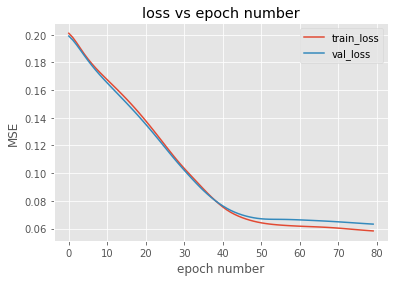

In [113]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [114]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:
Loss:  0.326635230981
Accuracy:  0.43781725888324874
Loss:  0.29422042048
Accuracy:  0.4746192893401015
Loss:  0.255467846605
Accuracy:  0.5482233502538071
Loss:  0.228304723392
Accuracy:  0.5685279187817259
Loss:  0.213513549046
Accuracy:  0.5824873096446701
Loss:  0.205851943547
Accuracy:  0.5862944162436549
Loss:  0.202725434567
Accuracy:  0.5786802030456852
Loss:  0.201107921956
Accuracy:  0.5862944162436549
Loss:  0.201678137923
Accuracy:  0.5850253807106599
Loss:  0.201614439641
Accuracy:  0.5786802030456852
Loss:  0.200853118539
Accuracy:  0.5799492385786802
Loss:  0.200844329991
Accuracy:  0.5799492385786802
Loss:  0.201736854101
Accuracy:  0.5786802030456852
Loss:  0.202609671297
Accuracy:  0.5786802030456852
Loss:  0.203040724683
Accuracy:  0.5761421319796954
Loss:  0.202929786053
Accuracy:  0.5774111675126904
Loss:  0.202248086419
Accuracy:  0.5761421319796954
Loss:  0.200985046352
Accuracy:  0.5786802030456852
Loss:  0.199138879237
Accuracy:  0.578

In [115]:
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss:  0.00207741362489
Accuracy:  0.9990871107053826

Precision: 0.15942028985507245
Recall: 0.8979591836734694
F-score: 0.27076923076923076


             actual 1  actual 0
predicted 1        88       464
predicted 0        10     56400


100%|██████████| 21/21 [00:56<00:00,  2.68s/it]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


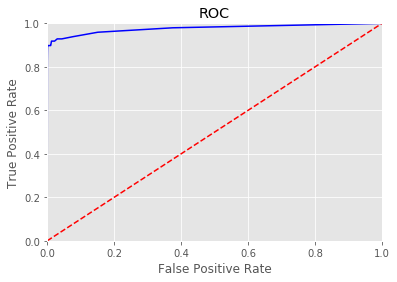

In [117]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)